# Music Genre Classification - Training Notebook

This notebook combines data loading from FMA dataset and model training into a single workflow.

## Steps:
1. Load FMA metadata and audio files
2. Create train/validation splits
3. Preprocess audio to log-mel spectrograms
4. Train CNN model for genre classification
5. Evaluate and save the best model

## 1. Import Required Libraries

In [18]:
import sys
from pathlib import Path
import importlib

# Ensure src directory is on sys.path for module imports
PROJECT_ROOT = Path.cwd()
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Reload config to pick up any recent edits (e.g., path changes)
import config
importlib.reload(config)
TRAINING_CONFIG = config.TRAINING_CONFIG
MODEL_CONFIG = config.MODEL_CONFIG
GENRE_LABELS = config.GENRE_LABELS
MODELS_DIR = config.MODELS_DIR
DATA_DIR = config.DATA_DIR

from model import create_model
from preprocessing import load_and_preprocess_audio, spec_augment

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Validate critical data paths early
tracks_csv = DATA_DIR / "fma_metadata" / "tracks.csv"
audio_root = DATA_DIR / "fma_medium"
print(f"Expecting metadata at: {tracks_csv}")
print(f"Expecting audio root at: {audio_root}")
if not tracks_csv.exists():
    raise FileNotFoundError(f"Missing tracks.csv at {tracks_csv}. Ensure dataset extracted to 'data/'.")
if not audio_root.exists():
    raise FileNotFoundError(f"Missing fma_medium audio directory at {audio_root}.")
print("✓ Dataset structure verified")

✓ All libraries imported successfully!
PyTorch version: 2.1.0+cpu
CUDA available: False
Expecting metadata at: c:\Users\amant\Documents\aaa-COLLEGE\aaa-semester 5\deep-learning-lab-aman\PROJECT 1\Music-classification-with-FMA-MEDIUM\data\fma_metadata\tracks.csv
Expecting audio root at: c:\Users\amant\Documents\aaa-COLLEGE\aaa-semester 5\deep-learning-lab-aman\PROJECT 1\Music-classification-with-FMA-MEDIUM\data\fma_medium
✓ Dataset structure verified


In [ ]:
# Setup logging to logs/training.log and CSV
import logging
import sys as _sys
from pathlib import Path as _Path

LOGS_DIR = config.LOGS_DIR
LOGS_DIR.mkdir(parents=True, exist_ok=True)

# Reconfigure root logger to avoid duplicate handlers on re-run
for _h in logging.root.handlers[:]:
    logging.root.removeHandler(_h)

log_file = LOGS_DIR / "training.log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.FileHandler(log_file, mode="w", encoding="utf-8"),
        logging.StreamHandler(_sys.stdout),
    ],
)
logger = logging.getLogger("train")

metrics_csv_path = LOGS_DIR / "training_metrics.csv"
if not metrics_csv_path.exists():
    with open(metrics_csv_path, "w", encoding="utf-8") as f:
        f.write("epoch,train_loss,train_acc,val_loss,val_acc,lr\n")

logger.info(f"Logging initialized. File: {log_file}")
logger.info(f"Metrics CSV: {metrics_csv_path}")

## 2. Load FMA Metadata

In [19]:
# Load FMA metadata with multi-level headers
metadata_path = DATA_DIR / "fma_metadata" / "tracks.csv"
print(f"Loading metadata from: {metadata_path}")

# FMA tracks.csv has multi-level column headers
tracks = pd.read_csv(metadata_path, index_col=0, header=[0, 1])

print(f"✓ Loaded {len(tracks)} tracks")
print(f"Columns: {tracks.columns.tolist()[:5]}...")  # Show first few columns

Loading metadata from: c:\Users\amant\Documents\aaa-COLLEGE\aaa-semester 5\deep-learning-lab-aman\PROJECT 1\Music-classification-with-FMA-MEDIUM\data\fma_metadata\tracks.csv
✓ Loaded 106574 tracks
Columns: [('album', 'comments'), ('album', 'date_created'), ('album', 'date_released'), ('album', 'engineer'), ('album', 'favorites')]...
✓ Loaded 106574 tracks
Columns: [('album', 'comments'), ('album', 'date_created'), ('album', 'date_released'), ('album', 'engineer'), ('album', 'favorites')]...


## 3. Prepare Dataset - Filter by Genres and Create File Paths

In [20]:
# Get the genre information (top level genre)
genre_top = tracks[('track', 'genre_top')]

# Filter to only medium subset tracks
subset = tracks[('set', 'subset')]
medium_tracks = tracks[subset == 'medium']

print(f"Tracks in medium subset: {len(medium_tracks)}")

# Create dataset from medium tracks with valid genres
audio_dir = DATA_DIR / "fma_medium"
samples = []

for track_id in tqdm(medium_tracks.index, desc="Processing tracks"):
    try:
        # Get genre
        genre = medium_tracks.loc[track_id, ('track', 'genre_top')]
        
        # Skip if genre not in our list
        if pd.isna(genre) or genre not in GENRE_LABELS:
            continue
        
        # Create file path: fma_medium/000/000001.mp3
        folder = str(track_id).zfill(6)[:3]
        file_path = audio_dir / folder / f"{str(track_id).zfill(6)}.mp3"
        
        # Check if file exists
        if file_path.exists():
            label_idx = GENRE_LABELS.index(genre)
            samples.append({
                'track_id': track_id,
                'path': str(file_path),
                'genre': genre,
                'label_idx': label_idx
            })
    except Exception as e:
        continue

# Create DataFrame
dataset_df = pd.DataFrame(samples)

print(f"\n✓ Created dataset with {len(dataset_df)} samples")
print(f"\nGenre distribution:")
print(dataset_df['genre'].value_counts())

Tracks in medium subset: 17000


Processing tracks: 100%|██████████| 17000/17000 [00:04<00:00, 3860.37it/s]


✓ Created dataset with 16490 samples

Genre distribution:
genre
Rock              6103
Electronic        5314
Experimental      1251
Hip-Hop           1201
Classical          619
Folk               519
Jazz               384
Instrumental       350
Pop                186
Country            178
Soul-RnB           154
Spoken             118
Blues               74
Easy Listening      21
International       18
Name: count, dtype: int64


## 4. Create Train/Validation Split

In [21]:
# Split dataset with stratification to maintain genre balance
train_df, val_df = train_test_split(
    dataset_df,
    test_size=0.2,
    stratify=dataset_df['label_idx'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

print("\nTraining set genre distribution:")
print(train_df['genre'].value_counts())

print("\nValidation set genre distribution:")
print(val_df['genre'].value_counts())

Training samples: 13192
Validation samples: 3298

Training set genre distribution:
genre
Rock              4883
Electronic        4251
Experimental      1001
Hip-Hop            961
Classical          495
Folk               415
Jazz               307
Instrumental       280
Pop                149
Country            143
Soul-RnB           123
Spoken              94
Blues               59
Easy Listening      17
International       14
Name: count, dtype: int64

Validation set genre distribution:
genre
Rock              1220
Electronic        1063
Experimental       250
Hip-Hop            240
Classical          124
Folk               104
Jazz                77
Instrumental        70
Pop                 37
Country             35
Soul-RnB            31
Spoken              24
Blues               15
Easy Listening       4
International        4
Name: count, dtype: int64


## 5. Define AudioDataset Class

In [22]:
class AudioDataset(Dataset):
    """Dataset class for loading and preprocessing audio files"""
    def __init__(self, file_list, labels, augment=False):
        self.file_list = file_list
        self.labels = labels
        self.augment = augment
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        # Load and preprocess audio to log-mel spectrogram
        spec = load_and_preprocess_audio(self.file_list[idx])
        
        # Apply augmentation if training
        if self.augment:
            spec = spec_augment(spec)
        
        # Convert to tensor and add channel dimension
        spec = torch.FloatTensor(spec).unsqueeze(0)  # (1, n_mels, time_frames)
        label = torch.LongTensor([self.labels[idx]])[0]
        
        return spec, label

print("✓ AudioDataset class defined")

✓ AudioDataset class defined


## 6. Create DataLoaders

In [23]:
# Create datasets
train_dataset = AudioDataset(
    train_df['path'].tolist(),
    train_df['label_idx'].tolist(),
    augment=True  # Apply augmentation for training
)

val_dataset = AudioDataset(
    val_df['path'].tolist(),
    val_df['label_idx'].tolist(),
    augment=False  # No augmentation for validation
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=True,
    num_workers=0  # Set to 0 for Windows compatibility
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAINING_CONFIG["batch_size"],
    shuffle=False,
    num_workers=0
)

print(f"✓ Created DataLoaders")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

✓ Created DataLoaders
Training batches: 413
Validation batches: 104


## 7. Initialize Model and Training Setup

In [24]:
# Setup device - Automatically select best GPU
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Found {num_gpus} CUDA device(s)")
    
    # List all GPUs and find the best one
    best_device = 0
    max_memory = 0
    
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory
        print(f"  GPU {i}: {gpu_name} ({gpu_memory / 1024**3:.2f} GB)")
        
        # Select GPU with most memory (usually the dedicated GPU)
        if gpu_memory > max_memory:
            max_memory = gpu_memory
            best_device = i
    
    device = torch.device(f"cuda:{best_device}")
    print(f"\n✓ SELECTED BEST GPU:")
    print(f"  Device: cuda:{best_device}")
    print(f"  GPU Name: {torch.cuda.get_device_name(best_device)}")
    print(f"  GPU Memory: {max_memory / 1024**3:.2f} GB")
else:
    device = torch.device("cpu")
    print(f"✓ SELECTED DEVICE: {device} (CUDA not available)")

# Create model
model = create_model(
    n_mels=MODEL_CONFIG["input_shape"][0],
    n_classes=MODEL_CONFIG["n_classes"]
).to(device)

print(f"✓ Model created with {sum(p.numel() for p in model.parameters())} parameters")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=TRAINING_CONFIG["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Training history
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

print("✓ Training setup complete")

✓ SELECTED DEVICE: cpu (CUDA not available)
✓ Model created with 423760 parameters
✓ Training setup complete
✓ Training setup complete


## 8. Define Training and Validation Functions

In [25]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for specs, labels in tqdm(dataloader, desc="Training", leave=False):
        specs, labels = specs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(specs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        total_loss += loss.item()
    
    return total_loss / len(dataloader), 100. * correct / total


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for specs, labels in tqdm(dataloader, desc="Validation", leave=False):
            specs, labels = specs.to(device), labels.to(device)
            
            outputs = model(specs)
            loss = criterion(outputs, labels)
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            total_loss += loss.item()
    
    return total_loss / len(dataloader), 100. * correct / total

print("✓ Training functions defined")

✓ Training functions defined


## 9. Training Loop

In [28]:
# Training loop
best_val_acc = 0
patience_counter = 0
patience = 10

print(f"Starting training for {TRAINING_CONFIG['epochs']} epochs...")
print(f"Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples")
print("-" * 70)

for epoch in range(TRAINING_CONFIG['epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Current LR for logging
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print progress
    print(f"Epoch {epoch+1}/{TRAINING_CONFIG['epochs']}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  LR: {current_lr:.6f}")
    
    # Log to file and append CSV
    try:
        logger.info(
            f"epoch={epoch+1} | train_loss={train_loss:.4f} train_acc={train_acc:.2f}% "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.2f}% lr={current_lr:.6f}"
        )
        with open(metrics_csv_path, 'a', encoding='utf-8') as f:
            f.write(f"{epoch+1},{train_loss:.4f},{train_acc:.2f},{val_loss:.4f},{val_acc:.2f},{current_lr:.6f}\n")
    except Exception:
        pass
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'models/best_model.pt')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
        try:
            logger.info(f"New best model saved (epoch={epoch+1}, val_acc={val_acc:.2f}%) -> {MODELS_DIR / 'best_model.pt'}")
        except Exception:
            pass
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            try:
                logger.info(f"Early stopping triggered after {epoch+1} epochs")
            except Exception:
                pass
            break
    
    print("-" * 70)

print(f"\n✓ Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
try:
    logger.info(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")
except Exception:
    pass

Starting training for 10 epochs...
Training on 13192 samples, validating on 3298 samples
----------------------------------------------------------------------


KeyboardInterrupt: 

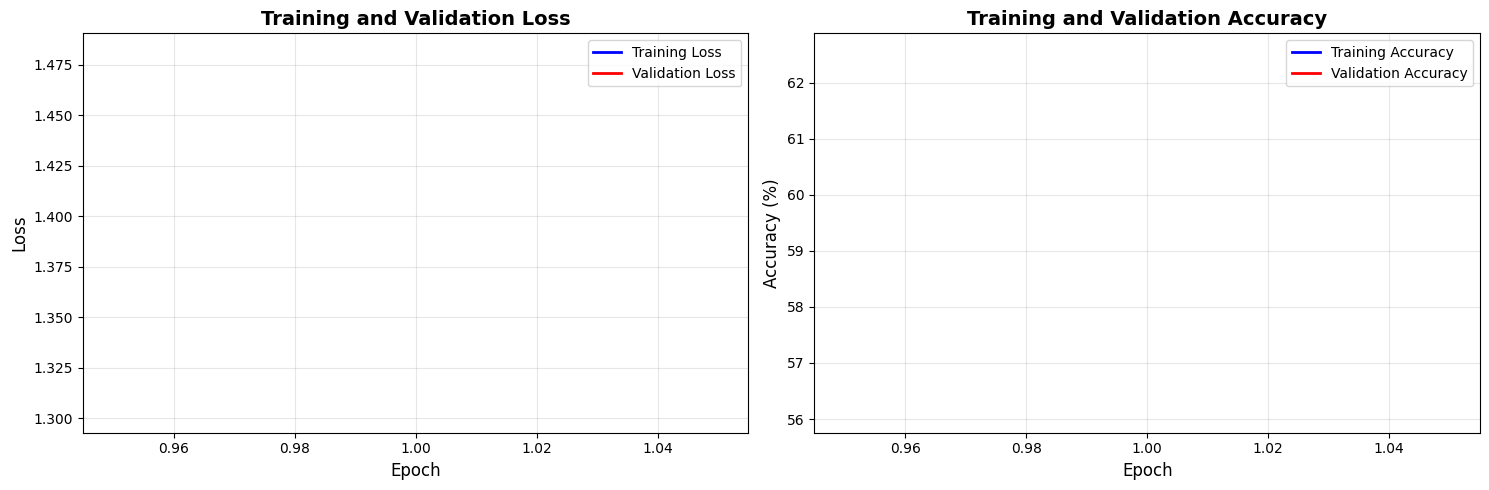

✓ Training curves saved to models/training_curves.png


In [29]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
epochs_range = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(epochs_range, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved to models/training_curves.png")

## 10. Visualize Training Progress

In [30]:
# Load best model and display final results
checkpoint = torch.load('models/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

print("=" * 70)
print("FINAL TRAINING SUMMARY")
print("=" * 70)
print(f"Best Epoch: {checkpoint['epoch'] + 1}")
print(f"Best Validation Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"Best Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"Total Epochs Trained: {len(history['train_loss'])}")
print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print("=" * 70)

# Display model architecture
print("\nMODEL ARCHITECTURE:")
print("-" * 70)
print(model)
print("-" * 70)

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

print(f"\n✓ Model saved to: models/best_model.pt")
print(f"✓ Ready to use with GUI application!")

FINAL TRAINING SUMMARY
Best Epoch: 1
Best Validation Accuracy: 62.55%
Best Validation Loss: 1.3018
Total Epochs Trained: 1
Training Samples: 13192
Validation Samples: 3298

MODEL ARCHITECTURE:
----------------------------------------------------------------------
GenreClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, mo

## 11. Final Evaluation & Model Summary

In [31]:
# Final evaluation: generate metrics and show confusion matrix
import sys
import json
from pathlib import Path
import importlib
from IPython.display import display
from IPython.display import Image as IPyImage

# Ensure config is current
import config
importlib.reload(config)
LOGS_DIR = config.LOGS_DIR
MODELS_DIR = config.MODELS_DIR

# 1) Verify best model exists
ckpt = MODELS_DIR / "best_model.pt"
if not ckpt.exists():
    print(f"⚠ best_model.pt not found at {ckpt}. Train and save a model first.")
else:
    print(f"✓ Found checkpoint: {ckpt}")

# 2) Run evaluator to create logs/metrics.json and logs/confusion_matrix.png
root = Path.cwd()
candidates = [root / "evaluate.py", root / "src" / "evaluate.py"]
eval_path = next((p for p in candidates if p.exists()), None)
if eval_path is None:
    print("⚠ evaluate.py not found. Skipping automatic evaluation.")
else:
    print(f"Running evaluator: {eval_path}")
    import subprocess
    cmd = [sys.executable, str(eval_path), "--limit", "300"]
    try:
        subprocess.run(cmd, cwd=str(root), check=False)
    except Exception as e:
        print(f"⚠ Evaluation failed: {e}")

# 3) Load and print metrics summary
metrics_path = LOGS_DIR / "metrics.json"
if metrics_path.exists():
    try:
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
        print("\n=== Evaluation Metrics ===")
        for k in ["accuracy", "precision_macro", "recall_macro", "f1_macro", "samples"]:
            if k in metrics:
                print(f"{k}: {metrics[k]}")
    except Exception as e:
        print(f"⚠ Failed to read metrics.json: {e}")
else:
    print(f"⚠ metrics.json not found at {metrics_path}")

# 4) Display confusion matrix if available
cm_candidates = [
    LOGS_DIR / "confusion_matrix.png",
    LOGS_DIR / "confusion-matrix.png",
    LOGS_DIR / "confusion_matrix.jpg",
    LOGS_DIR / "confusion-matrix.jpg",
]
cm_path = next((p for p in cm_candidates if p.exists()), None)
if cm_path is not None:
    print(f"\nDisplaying confusion matrix: {cm_path}")
    display(IPyImage(filename=str(cm_path)))
else:
    print("⚠ Confusion matrix image not found in logs/.")

✓ Found checkpoint: c:\Users\amant\Documents\aaa-COLLEGE\aaa-semester 5\deep-learning-lab-aman\PROJECT 1\Music-classification-with-FMA-MEDIUM\models\best_model.pt
Running evaluator: c:\Users\amant\Documents\aaa-COLLEGE\aaa-semester 5\deep-learning-lab-aman\PROJECT 1\Music-classification-with-FMA-MEDIUM\evaluate.py
⚠ metrics.json not found at c:\Users\amant\Documents\aaa-COLLEGE\aaa-semester 5\deep-learning-lab-aman\PROJECT 1\Music-classification-with-FMA-MEDIUM\logs\metrics.json
⚠ Confusion matrix image not found in logs/.
⚠ metrics.json not found at c:\Users\amant\Documents\aaa-COLLEGE\aaa-semester 5\deep-learning-lab-aman\PROJECT 1\Music-classification-with-FMA-MEDIUM\logs\metrics.json
⚠ Confusion matrix image not found in logs/.
